## EDA on original dataset

In [42]:
import os

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
!ls tmp/market_1501_metric_learning

bounding_box_train test.csv           train.csv


In [6]:
!ls tmp/market_1501_metric_learning/bounding_box_train | wc -l

   12936


In [88]:
im_dir = 'tmp/market_1501_metric_learning/bounding_box_train'

In [64]:
d_train = pd.read_csv('tmp/market_1501_metric_learning/train.csv', dtype = {'label':'object'})
d_test = pd.read_csv('tmp/market_1501_metric_learning/test.csv', dtype = {'label':'object'})
d_train.shape, d_test.shape

((12936, 3), (534, 3))

In [65]:
d_train

,image_id,label,fold
0,0517_c5s1_143520_02.jpg,0517,4
1,0816_c6s2_104418_01.jpg,0816,6
2,1278_c1s6_012016_02.jpg,1278,7
3,0508_c5s2_082302_02.jpg,0508,1
4,1198_c6s3_034292_01.jpg,1198,8
...,...,...,...
12931,1454_c5s3_058740_07.jpg,1454,3
12932,1479_c6s3_084617_02.jpg,1479,5
12933,0208_c2s1_045276_03.jpg,0208,1
12934,0726_c6s2_075643_01.jpg,0726,4


In [66]:
d_train['fold'].value_counts()

2    1583
3    1561
5    1449
7    1395
0    1234
1    1224
6    1162
9    1141
4    1099
8    1088
Name: fold, dtype: int64

In [67]:
d_train['label'].nunique()

751

In [68]:
#d_train['label'] = 'id' + d_train['label']

In [69]:
d_test

,image_id,label,fold
0,0111_c5s1_019051_04.jpg,0111,0
1,0340_c5s1_080648_05.jpg,0340,0
2,0641_c1s3_044426_01.jpg,0641,0
3,0279_c3s1_154833_03.jpg,0279,0
4,1368_c1s5_069791_04.jpg,1368,0
...,...,...,...
529,0484_c5s1_126720_01.jpg,0484,0
530,0832_c2s3_063427_14.jpg,0832,0
531,1078_c4s5_008004_01.jpg,1078,0
532,0427_c3s1_104367_04.jpg,0427,0


In [70]:
d_test['fold'].value_counts()

0    534
Name: fold, dtype: int64

In [71]:
d_test['label'].nunique()

68

In [72]:
#d_test['label'] = 'id' + d_test['label']

### ラベルの割り振り（共通ラベル、片方にしかないラベル）を確認

In [73]:
d_label = pd.DataFrame({'train_label':d_train['label'].value_counts(), 'test_label':d_test['label'].value_counts()})
d_label = d_label.reset_index()
d_label = d_label.rename({'index':'label'}, axis='columns')
d_label

,label,train_label,test_label
0,0002,46,NaN
1,0007,7,NaN
2,0010,11,NaN
3,0011,15,NaN
4,0012,6,NaN
...,...,...,...
746,1489,7,NaN
747,1492,15,NaN
748,1495,33,NaN
749,1496,16,NaN


In [130]:
d_label.sort_values(['train_label','test_label'], ascending=False).to_csv('label_distribution.csv', index=False)

In [83]:
# Trainのlabel数
d_label.sort_values('train_label')

,label,train_label,test_label
35,0084,2,NaN
62,0129,2,NaN
728,1451,2,2.0
23,0059,3,3.0
75,0151,3,NaN
...,...,...,...
6,0022,59,NaN
104,0208,63,NaN
136,0272,67,NaN
46,0105,70,NaN


In [82]:
# NAをのぞいたtest_labelにおけるlabel数
d_label[d_label['test_label'].notna()].sort_values('test_label')

,label,train_label,test_label
20,0053,5,1.0
263,0509,6,1.0
311,0599,8,1.0
334,0640,7,1.0
728,1451,2,2.0
...,...,...,...
171,0340,27,15.0
594,1135,25,15.0
335,0641,18,15.0
98,0197,39,23.0


In [75]:
# test_labelがNAでないデータ
d_label[d_label['test_label'].notna()]

,label,train_label,test_label
13,0037,20,13.0
20,0053,5,1.0
23,0059,3,3.0
41,0097,8,6.0
43,0099,5,3.0
...,...,...,...
690,1368,11,5.0
693,1379,17,6.0
720,1433,16,7.0
725,1445,13,7.0


In [78]:
# train_labelがNAのデータ
d_label[d_label['train_label'].isna()]

,label,train_label,test_label


In [79]:
# train_labelがNAでないデータ
d_label[d_label['train_label'].notna()]

,label,train_label,test_label
0,0002,46,NaN
1,0007,7,NaN
2,0010,11,NaN
3,0011,15,NaN
4,0012,6,NaN
...,...,...,...
746,1489,7,NaN
747,1492,15,NaN
748,1495,33,NaN
749,1496,16,NaN


 - Unique ID数は751
 - Trainに有り、Testに無いIDは64
 - Testにのみ有るIDは存在しない

### 画像サイズ統計量

In [89]:
H, W, C = [], [], []
v_mean, v_min, v_max = [], [], []
im_pathes = []
for f in d_train['image_id']:
    im_path = os.path.join(im_dir, f)
    im_pathes.append(im_path)
    im = cv2.imread(im_path)
    H.append(im.shape[0])
    W.append(im.shape[1])
    C.append(im.shape[2])
    v_mean.append(im.mean())
    v_min.append(im.min()*1.0)
    v_max.append(im.max()*1.0)
df_train_shape = pd.DataFrame({'H':H, 'W':W, 'C':C, 'val_mean':v_mean, 'val_min':v_min, 'val_max':v_max})
df_train_shape.shape

(12936, 6)

In [90]:
df_train_shape

,H,W,C,val_mean,val_min,val_max
0,128,64,3,86.020101,9.0,236.0
1,128,64,3,84.347331,0.0,249.0
2,128,64,3,77.956746,0.0,195.0
3,128,64,3,106.704346,0.0,255.0
4,128,64,3,60.731445,0.0,213.0
...,...,...,...,...,...,...
12931,128,64,3,113.351644,0.0,255.0
12932,128,64,3,52.288696,0.0,249.0
12933,128,64,3,110.783447,8.0,255.0
12934,128,64,3,100.408569,5.0,255.0


In [93]:
df_train_shape.describe()

,H,W,C,val_mean,val_min,val_max
count,12936.0,12936.0,12936.0,12936.000000,12936.000000,12936.000000
mean,128.0,64.0,3.0,100.910903,2.648578,247.967301
std,0.0,0.0,0.0,19.921303,4.458202,14.809365
min,128.0,64.0,3.0,30.673787,0.000000,119.000000
25%,128.0,64.0,3.0,87.878082,0.000000,250.000000
50%,128.0,64.0,3.0,100.800049,0.000000,255.000000
75%,128.0,64.0,3.0,113.822978,4.000000,255.000000
max,128.0,64.0,3.0,183.416178,58.000000,255.000000


In [91]:
H, W, C = [], [], []
v_mean, v_min, v_max = [], [], []
im_pathes = []
for f in d_test['image_id']:
    im_path = os.path.join(im_dir, f)
    im_pathes.append(im_path)
    im = cv2.imread(im_path)
    H.append(im.shape[0])
    W.append(im.shape[1])
    C.append(im.shape[2])
    v_mean.append(im.mean())
    v_min.append(im.min()*1.0)
    v_max.append(im.max()*1.0)
df_test_shape = pd.DataFrame({'H':H, 'W':W, 'C':C, 'val_mean':v_mean, 'val_min':v_min, 'val_max':v_max})
df_test_shape.shape

(534, 6)

In [92]:
df_test_shape

,H,W,C,val_mean,val_min,val_max
0,128,64,3,99.309652,0.0,255.0
1,128,64,3,125.545492,0.0,255.0
2,128,64,3,75.350667,0.0,231.0
3,128,64,3,116.785400,1.0,255.0
4,128,64,3,104.453898,1.0,219.0
...,...,...,...,...,...,...
529,128,64,3,94.474040,0.0,209.0
530,128,64,3,109.311076,4.0,255.0
531,128,64,3,130.854207,12.0,255.0
532,128,64,3,102.833252,0.0,255.0


In [94]:
df_test_shape.describe()

,H,W,C,val_mean,val_min,val_max
count,534.0,534.0,534.0,534.000000,534.000000,534.000000
mean,128.0,64.0,3.0,100.410654,2.647940,247.061798
std,0.0,0.0,0.0,21.904534,4.331873,15.890394
min,128.0,64.0,3.0,39.748657,0.000000,151.000000
25%,128.0,64.0,3.0,87.229858,0.000000,248.250000
50%,128.0,64.0,3.0,99.680766,0.000000,255.000000
75%,128.0,64.0,3.0,115.571960,4.750000,255.000000
max,128.0,64.0,3.0,175.963257,27.000000,255.000000


### label別の画像の表示

In [103]:
# Trainデータにおいて、ある一定数画像が存在するlabelを抽出
d_tmp = d_label.sort_values('train_label', ascending=False)
d_tmp

,label,train_label,test_label
67,0139,72,NaN
46,0105,70,NaN
136,0272,67,NaN
104,0208,63,NaN
6,0022,59,NaN
...,...,...,...
159,0323,3,NaN
75,0151,3,NaN
35,0084,2,NaN
62,0129,2,NaN


In [104]:
d_tmp['train_label'].describe()

count    751.000000
mean      17.225033
std       10.773484
min        2.000000
25%        9.000000
50%       15.000000
75%       22.000000
max       72.000000
Name: train_label, dtype: float64

In [108]:
labels = d_tmp['label'][d_tmp['train_label']>=15]
len(labels)

402

In [110]:
labels.sample(10)

486    0933
215    0411
600    1158
127    0251
76     0158
323    0620
511    0973
282    0547
89     0178
325    0623
Name: label, dtype: object

In [114]:
# 10種類(label)をランダムで選択
d = d_train[d_train['label'].isin(labels.sample(10))]

['1162', '1391', '0623', '1291', '0914', '0709', '0370', '0976', '0368', '1081']


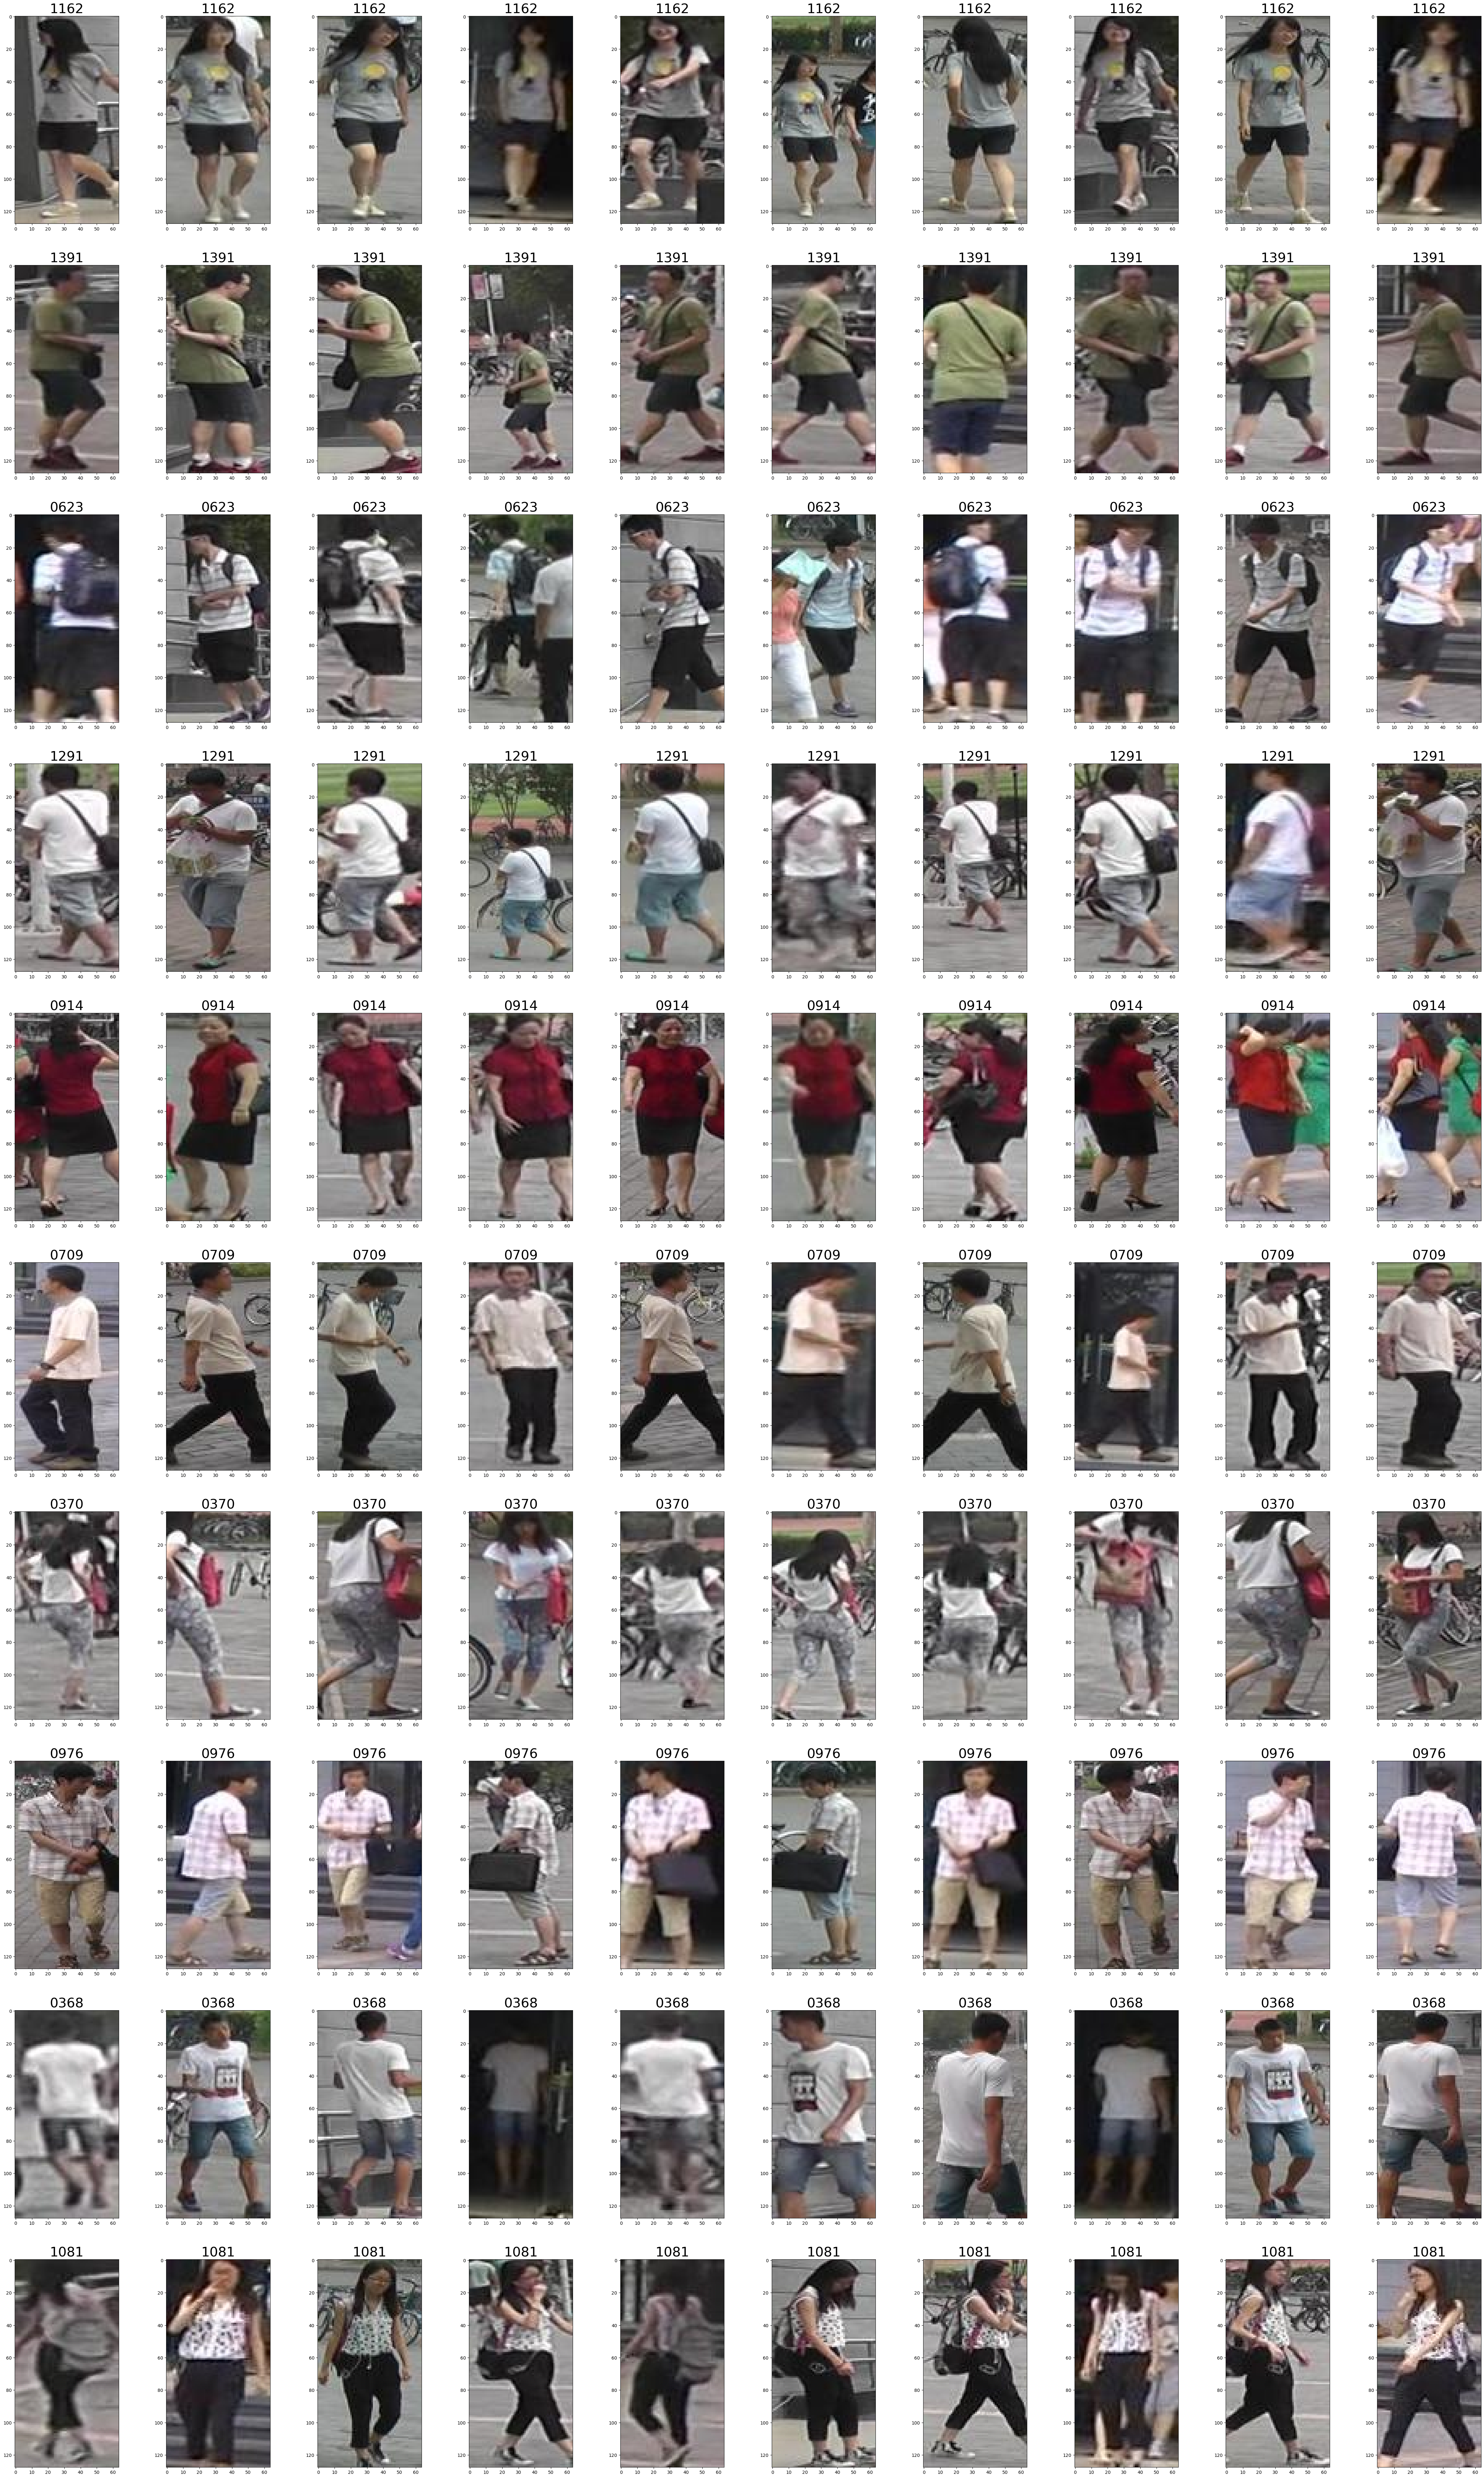

In [127]:
# ランダムにLabel別画像を表示

### ランダムサンプリング
sample_img_path = {}   # label:image_path 形式で表示データを保存
keys = d['label'].unique().tolist()
print(keys)
N = 10   # num of samples from each class

sampled_images = d.groupby('label').apply(lambda x: x.sample(n=N))   # ランダムにサンンプリング

for k in keys:
    tmp = sampled_images[sampled_images['label']==k]['image_id']
    sample_img_path[k] = [os.path.join('tmp', 'market_1501_metric_learning', 'bounding_box_train', i) for i in tmp]
#sample_img_path

### プロット
fig = plt.figure(figsize=(60, 150))
counter = 1
for k in sample_img_path.keys():
    #print(k)
    for v in sample_img_path[k]:
        #print(v)
        #print(counter)
        ax = fig.add_subplot(15, N, counter)
        ax.set_title(k, fontsize=30)
        im = cv2.imread(v)
        converted_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.imshow(converted_im)
        counter = counter + 1